In [1052]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin, clone
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import StackingRegressor
from sklearn.preprocessing import RobustScaler
from scipy.interpolate import UnivariateSpline
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from statsmodels.api import OLS
from scipy.stats import norm
import statsmodels.api as sm
from scipy import stats
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

In [1053]:
def load_data(train_path, test_path):
    train_data = pd.read_csv(train_path)
    test_data = pd.read_csv(test_path)
    return train_data, test_data

In [1054]:
def visualize_data(data, features):
    for feature in features:
        plt.figure(figsize=(10, 4))

        # Boxplot for outlier detection
        plt.subplot(1, 2, 1)
        sns.boxplot(data[feature])
        plt.title(f'Boxplot of {feature}')

        # Histogram for distribution
        plt.subplot(1, 2, 2)
        sns.histplot(data[feature], kde=True)
        plt.title(f'Distribution of {feature}')

        plt.show()

In [1055]:
def plot_residuals(residuals, y_pred):
    plt.scatter(y_pred, residuals)
    plt.title('Residuals vs. Predicted Values')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.show()

In [1056]:
def normality(residuals):
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title('Normal Q-Q plot')
    plt.show()

In [1057]:
def preprocess_data(data, features, imputer):
    data[features] = imputer.transform(data[features])
    return data

In [1058]:
def train_model_statsmodels(X, y):
    X = sm.add_constant(X)  # Adding a constant to the model
    model = sm.OLS(y, X).fit(cov_type='HC0')
    return model

In [1059]:
def generate_polynomials(data):
    poly = PolynomialFeatures(degree=2, include_bias=True)
    data = poly.fit_transform(data)

    #feature_names = poly.get_feature_names_out()
    #data = pd.DataFrame(data, columns=feature_names)
    return data

In [1060]:
def select_features(X, y, top=100):
    lasso = Lasso(alpha =0.05, random_state=1)
    lasso.fit(X, y)
    
    weights = lasso.coef_
    top = min(len(weights), top)
    
    threshold = np.sort(np.abs(weights))[-top]
    
    # Identify columns with weight below 0.5
    columns_to_delete = [column for column, weight in zip(list(lasso.feature_names_in_), weights) if abs(weight) <= threshold]

    # Delete these columns from X
    X = X.drop(columns=columns_to_delete)
    return X.columns

In [1061]:
ordinal_mapping = {
    'Ex': 5,  # Excellent
    'Gd': 4,  # Good
    'TA': 3,  # Average/Typical
    'Fa': 2,  # Fair
    'Po': 1,  # Poor
    'NA': 0   # None
}

def data_mapping(train_data, test_data, column, mapping=ordinal_mapping):
    train_data[column] = train_data[column].map(mapping)
    test_data[column] = test_data[column].map(mapping)
    return train_data[column], test_data[column]

In [1062]:
# Paths to the datasets
train_path = 'train.csv'
test_path = 'test.csv'

# Load the data
train_data, test_data = load_data(train_path, test_path)
#train_data.drop([88,462,523,588,632,968,1298,1324], inplace=True)

original_train = pd.read_csv(train_path)

data_mapping(train_data, test_data, 'KitchenQual')
data_mapping(train_data, test_data, 'HeatingQC')
             
#convert categorical variable into dummy
train_data = pd.get_dummies(train_data)
test_data = pd.get_dummies(test_data)

# Visualize data
selected_features = ['HeatingQC', 'MasVnrArea', 'KitchenQual', 'SaleCondition_Normal', 'ExterQual_TA', 'LotArea',
                     'YrSold', 'OverallQual', 'OverallCond', 'GrLivArea', 'TotalBsmtSF','GarageCars', 'MSSubClass', 'YearBuilt']
#visualize_data(train_data, selected_features)

In [1063]:
# Handling missing values
imputer = SimpleImputer(strategy='constant', fill_value=0)
train_data[selected_features] = imputer.fit_transform(train_data[selected_features])

# Preprocessing the test data
test_data = preprocess_data(test_data, selected_features, imputer)

# Apply log transformation to the target variable 'SalePrice'
train_data['SalePrice'] = np.log1p(train_data['SalePrice'])
y = train_data['SalePrice']
X = train_data[selected_features]

X_poly = generate_polynomials(X)
X_test = generate_polynomials(test_data[selected_features])

X_train, X_val, y_train, y_val = train_test_split(X_poly, y, test_size=0.1, random_state=0)
'''
X_poly = generate_polynomials(X_poly)
X_test = generate_polynomials(X_test)

selected_features_lasso = select_features(X_poly, y, top=100)

X_poly = X_poly[selected_features_lasso]
X_test = X_test[selected_features_lasso]
'''

'\nX_poly = generate_polynomials(X_poly)\nX_test = generate_polynomials(X_test)\n\nselected_features_lasso = select_features(X_poly, y, top=100)\n\nX_poly = X_poly[selected_features_lasso]\nX_test = X_test[selected_features_lasso]\n'

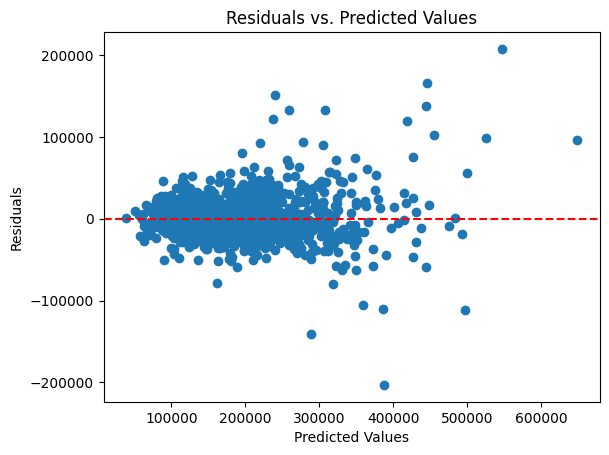

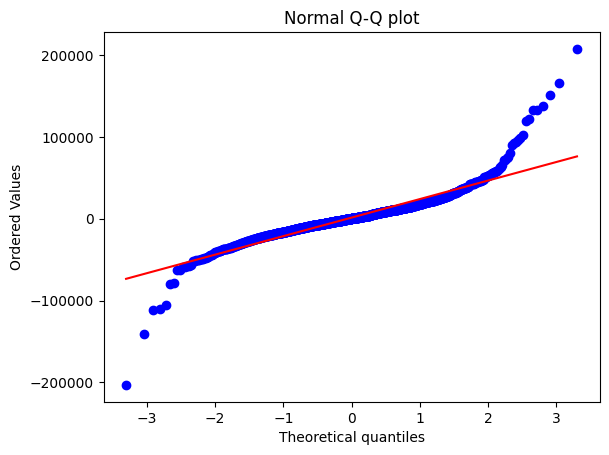

R-squared value: 0.9055941499708225


In [1064]:
# Training the models
model = train_model_statsmodels(X_poly, y)

# Evaluating the model
X_poly = sm.add_constant(X_poly)  # Adding a constant to the validation data
y_pred_log =model.predict(X_poly)  # Predicted log-transformed prices
y_pred = np.expm1(y_pred_log)  # Inverse transformation
r_squared = r2_score(np.expm1(y), y_pred)
residuals = np.expm1(y) - y_pred
plot_residuals(residuals, y_pred)
normality(residuals)
print("R-squared value:", r_squared)

In [1065]:
'''
weights = lasso.coef_
plt.hist(weights, bins=50, log=True)

# Identify columns with weight below 0.5
columns_to_delete = [column for column, weight in zip(list(lasso.feature_names_in_), weights) if abs(weight) <= 3e-10]

# Delete these columns from X
X_filtered = X_poly.drop(columns=columns_to_delete)
X_filtered_test = X_test.drop(columns=columns_to_delete)
X_filtered_test
'''

'\nweights = lasso.coef_\nplt.hist(weights, bins=50, log=True)\n\n# Identify columns with weight below 0.5\ncolumns_to_delete = [column for column, weight in zip(list(lasso.feature_names_in_), weights) if abs(weight) <= 3e-10]\n\n# Delete these columns from X\nX_filtered = X_poly.drop(columns=columns_to_delete)\nX_filtered_test = X_test.drop(columns=columns_to_delete)\nX_filtered_test\n'

In [1066]:
'''
model = train_model_statsmodels(X_filtered, y_train)

# Evaluating the model
X_filtered = sm.add_constant(X_filtered)  # Adding a constant to the validation data
y_pred_log =model.predict(X_filtered)  # Predicted log-transformed prices
y_pred = np.expm1(y_pred_log)  # Inverse transformation
r_squared = r2_score(np.expm1(y), y_pred)
residuals = np.expm1(y) - y_pred
plot_residuals(residuals, y_pred)
normality(residuals)
print("R-squared value:", r_squared)
'''

'\nmodel = train_model_statsmodels(X_filtered, y_train)\n\n# Evaluating the model\nX_filtered = sm.add_constant(X_filtered)  # Adding a constant to the validation data\ny_pred_log =model.predict(X_filtered)  # Predicted log-transformed prices\ny_pred = np.expm1(y_pred_log)  # Inverse transformation\nr_squared = r2_score(np.expm1(y), y_pred)\nresiduals = np.expm1(y) - y_pred\nplot_residuals(residuals, y_pred)\nnormality(residuals)\nprint("R-squared value:", r_squared)\n'

In [1067]:
# Predicting the housing prices for the test data
X_test = sm.add_constant(X_test)  # Adding a constant to the test data
predicted_log_prices = model.predict(X_test)  # Predicted log-transformed prices for test data
predicted_prices = np.expm1(predicted_log_prices)  # Inverse transformation for test data predictions

In [1068]:
''
# Saving the predictions
predicted_prices_df = pd.DataFrame({
    'Id': test_data['Id'],
    'SalePrice': predicted_prices
})
predicted_prices_df.to_csv('predicted_housing_prices_statsmodels.csv', index=False)
''

''

In [1069]:
train_data.columns.tolist()

['Id',
 'MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'HeatingQC',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'KitchenQual',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold',
 'SalePrice',
 'MSZoning_C (all)',
 'MSZoning_FV',
 'MSZoning_RH',
 'MSZoning_RL',
 'MSZoning_RM',
 'Street_Grvl',
 'Street_Pave',
 'Alley_Grvl',
 'Alley_Pave',
 'LotShape_IR1',
 'LotShape_IR2',
 'LotShape_IR3',
 'LotShape_Reg',
 'LandContour_Bnk',
 'LandContour_HLS',
 'LandContour_Low',
 'LandContour_Lvl',
 'Utilities_AllPub',
 'Utilities_NoSeWa',
 'LotConfig_Corner',
 'LotConfig_CulDSac',
 'LotConfig_FR2',
 'LotConfig_FR3

In [1070]:
error = np.expm1(y) - y_pred
error = np.abs(error)
error_ascending = error.sort_values()
train_data['error'] = error
train_data.sort_values(by='error')

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,error
1195,1196,60.0,51.0,8029.0,6.0,5.0,2005.0,2005,0.0,0,...,False,False,True,False,False,False,False,1.0,False,13.627098
1323,1324,30.0,50.0,5330.0,4.0,7.0,1940.0,1950,0.0,280,...,False,False,True,False,False,False,False,1.0,False,30.650852
1206,1207,20.0,NaN,8900.0,4.0,4.0,1966.0,1966,0.0,1056,...,False,False,True,False,False,False,False,1.0,False,52.390937
1416,1417,190.0,60.0,11340.0,4.0,6.0,1885.0,1950,0.0,0,...,False,False,True,False,False,False,False,1.0,False,55.960603
1184,1185,20.0,50.0,35133.0,5.0,4.0,1963.0,1963,226.0,1159,...,False,False,True,False,False,False,False,1.0,False,72.144638
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1324,1325,20.0,75.0,9986.0,8.0,5.0,2006.0,2007,428.0,0,...,True,False,False,False,False,False,False,0.0,True,141358.917816
688,689,20.0,60.0,8089.0,8.0,6.0,2007.0,2007,0.0,945,...,True,False,False,False,False,False,False,0.0,True,151444.330843
898,899,20.0,100.0,12919.0,9.0,5.0,2009.0,2010,760.0,2188,...,True,False,False,False,False,False,False,0.0,True,165673.160736
523,524,60.0,130.0,40094.0,10.0,5.0,2007.0,2008,762.0,2260,...,True,False,False,False,False,False,False,0.0,True,203017.724458


In [1071]:
train_merged = pd.merge(original_train, train_data[['Id', 'error']], on='Id')
train_merged

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,error
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2008,WD,Normal,208500,5124.779880
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,5,2007,WD,Normal,181500,590.123485
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,9,2008,WD,Normal,223500,10713.934265
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000,21005.283114
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,12,2008,WD,Normal,250000,40759.251761
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,8,2007,WD,Normal,175000,8111.561157
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000,1607.951560
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500,26455.234846
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,4,2010,WD,Normal,142125,13901.500467


In [1072]:
train_merged.sort_values(by='error')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,error
1195,1196,60,RL,51.0,8029,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,7,2008,WD,Normal,176000,13.627098
1323,1324,30,RL,50.0,5330,Pave,NaN,Reg,HLS,AllPub,...,NaN,NaN,NaN,0,12,2009,WD,Normal,82500,30.650852
1206,1207,20,RH,NaN,8900,Pave,NaN,Reg,Lvl,AllPub,...,NaN,MnPrv,NaN,0,11,2006,WD,Normal,107000,52.390937
1416,1417,190,RM,60.0,11340,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,4,2010,WD,Normal,122500,55.960603
1184,1185,20,RL,50.0,35133,Grvl,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,5,2007,WD,Normal,186700,72.144638
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1324,1325,20,RL,75.0,9986,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2007,New,Partial,147000,141358.917816
688,689,20,RL,60.0,8089,Pave,NaN,Reg,HLS,AllPub,...,NaN,NaN,NaN,0,10,2007,New,Partial,392000,151444.330843
898,899,20,RL,100.0,12919,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,3,2010,New,Partial,611657,165673.160736
523,524,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,...,NaN,NaN,NaN,0,10,2007,New,Partial,184750,203017.724458


In [1073]:
correlations = pd.get_dummies(train_merged).astype(np.float64).corrwith(train_merged['error'])
correlations.sort_values().tail(50)

RoofStyle_Flat           0.093626
Exterior2nd_CmentBd      0.094877
Condition1_PosN          0.095851
LandSlope_Mod            0.102368
LotShape_IR1             0.103384
Exterior1st_CemntBd      0.111556
RoofMatl_WdShngl         0.127396
WoodDeckSF               0.128886
Neighborhood_Crawfor     0.134708
Neighborhood_NoRidge     0.135329
YearBuilt                0.141293
GarageYrBlt              0.143288
LandContour_HLS          0.148209
BsmtUnfSF                0.148568
LotArea                  0.149003
RoofStyle_Hip            0.153055
OpenPorchSF              0.154265
Neighborhood_StoneBr     0.156460
ExterQual_Gd             0.157310
BsmtFinType1_GLQ         0.158104
HeatingQC_Ex             0.159278
Neighborhood_NridgHt     0.159837
2ndFlrSF                 0.161525
GarageFinish_Fin         0.161746
YearRemodAdd             0.168108
FireplaceQu_Ex           0.172195
MasVnrType_Stone         0.175827
Foundation_PConc         0.181455
FireplaceQu_Gd           0.186742
BsmtFinSF1    